In [1]:
import numpy as np
import sqlite3
import pickle
import cv2
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from sklearn.neighbors import NearestNeighbors



import embedding_resnet_final
import histograms_commented


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Failed to load the image. Please check the file path.
D:/data/image_data\weather_image_recognition\dew\2208.jpg
D:/data/image_data\weather_image_recognition\dew\2209.jpg
D:/data/image_data\weather_image_recognition\dew\2210.jpg
D:/data/image_data\weather_image_recognition\dew\2211.jpg
D:/data/image_data\weather_image_recognition\dew\2212.jpg
D:/data/image_data\weather_image_recognition\dew\2213.jpg
D:/data/image_data\weather_image_recognition\dew\2214.jpg
D:/data/image_data\weather_image_recognition\dew\2215.jpg
D:/data/image_data\weather_image_recognition\dew\2216.jpg
D:/data/image_data\weather_image_recognition\dew\2217.jpg


## Connect to the database and save all paths

In [2]:
database_name = "database_all_images.db"
root_folder = r"D:/data/image_data"

conn = sqlite3.connect(database_name)
c = conn.cursor()
conn.commit()


In [3]:
c.execute("SELECT Path FROM Images")

# Fetch all results
paths_tuples = c.fetchall()  # This will be a list of tuples

# Convert list of tuples to a list of strings
database_image_paths = [path[0] for path in paths_tuples]  # Extract the first element of each tuple

# Verify the paths
for path in database_image_paths[:10]:  # Print the first 10 paths for verification
    print(path)

D:/data/image_data\weather_image_recognition\dew\2208.jpg
D:/data/image_data\weather_image_recognition\dew\2209.jpg
D:/data/image_data\weather_image_recognition\dew\2210.jpg
D:/data/image_data\weather_image_recognition\dew\2211.jpg
D:/data/image_data\weather_image_recognition\dew\2212.jpg
D:/data/image_data\weather_image_recognition\dew\2213.jpg
D:/data/image_data\weather_image_recognition\dew\2214.jpg
D:/data/image_data\weather_image_recognition\dew\2215.jpg
D:/data/image_data\weather_image_recognition\dew\2216.jpg
D:/data/image_data\weather_image_recognition\dew\2217.jpg


In [4]:
# Load the ResNet50 model pre-trained on ImageNet (taktes around 2 sec)
base_model = ResNet50(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

In [5]:
# Load embeddings and histograms from pickle files
with open('embeddings_all.pkl', 'rb') as f:
    embeddings = pickle.load(f)

histograms = histograms_commented.load_histograms_from_file("histograms_all_images_0608.pkl")


In [6]:


#todo
def find_similar_images(input_img_path, model, embeddings, image_paths, histograms, top_n_embeddings=1000, top_n_histograms=5):
    # Step 1: Find similar images based on embeddings
    input_embedding = embedding_resnet_final.extract_embedding(input_img_path, model)(input_img_path, model)
    if input_embedding is None:
        print(f"Failed to extract embedding for input image: {input_img_path}")
        return []

    similarities = cosine_similarity([input_embedding], embeddings)[0]
    indices = np.argsort(similarities)[::-1][:top_n_embeddings]  # top N closest images based on embeddings
    closest_image_paths = [image_paths[i] for i in indices]

    # Extract histograms for the closest images
    closest_histograms = [histograms[i] for i in indices]

    # Extract histogram for the input image
    input_histogram = histograms_commented.calculate_histogram(input_img_path, "HSV")

    # Step 2: Find similar images based on histograms among the closest ones
    if input_histogram is None:
        print(f"Failed to extract histogram for input image: {input_img_path}")
        return []

    histogram_similarities = pairwise_distances([input_histogram], closest_histograms, metric='euclidean')[0]
    histogram_indices = np.argsort(histogram_similarities)[:top_n_histograms]

    similar_images = [(closest_image_paths[i], histogram_similarities[i]) for i in histogram_indices]
    
    return similar_images



In [7]:
def find_similar_images(input_img_path, model, embeddings, image_paths, histograms, top_n_embeddings=1000, top_n_histograms=5):
    # Step 1: Find similar images based on embeddings
    input_embedding = embedding_resnet_final.extract_embedding(input_img_path, model)
    if input_embedding is None:
        print(f"Failed to extract embedding for input image: {input_img_path}")
        return []
    
    similarities = cosine_similarity([input_embedding], embeddings)[0]
    indices = np.argsort(similarities)[::-1][:top_n_embeddings]  # top N closest images based on embeddings
    closest_image_paths = [image_paths[i] for i in indices]
    print(f"Embedding Similarities Calculated")
    # Extract histograms for the closest images
    closest_histograms = [histograms[path] for path in closest_image_paths if path in histograms]
   
    # Load the input image
    input_image = cv2.imread(input_img_path)
    if input_image is None:
        print(f"Failed to load input image: {input_img_path}")
        return []

    # Extract histogram for the input image
    input_histogram = histograms_commented.calculate_histogram(input_image, "HSV")

    # Step 2: Find similar images based on histograms among the closest ones
    if input_histogram is None:
        print(f"Failed to extract histogram for input image: {input_img_path}")
        return []
    print("Calculating Distances...")
    histogram_similarities = pairwise_distances([input_histogram], closest_histograms, metric='euclidean')[0]
    histogram_similarities = histogram_similarities / np.max(histogram_similarities)
    print(f"histograms Similarities Calculated")
    histogram_indices = np.argsort(histogram_similarities)[:top_n_histograms]
    similar_images = [(closest_image_paths[i], histogram_similarities[i]) for i in histogram_indices]
    
    return similar_images

In [61]:
def find_similar_images(input_img_path, model, embeddings, image_paths, histograms, top_n_embeddings=1000, top_n_histograms=5):
    """
    This function finds images in the database that are most similar to the input image based on a combination of embeddings and histograms.

    Input:
    - input_img_path: The file path of the input image.
    - model: The model used to extract embeddings.
    - embeddings: A NumPy array containing the embeddings of all images in the database.
    - image_paths: A list of paths to the images corresponding to the embeddings.
    - histograms: A dictionary where keys are image paths and values are the corresponding histograms.
    - top_n_embeddings: Number of top similar images to select based on embeddings (default is 1000).
    - top_n_histograms: Number of top similar images to select based on histograms (default is 5).

    Output:
    - A list of tuples where each tuple contains an image path and the corresponding similarity score.
      The list is ordered by similarity, with the most similar image first.
    """
    # Step 1: Find similar images based on embeddings
    input_embedding = embedding_resnet_final.extract_embedding(input_img_path, model)
    if input_embedding is None:
        print(f"Failed to extract embedding for input image: {input_img_path}")
        return []
    
    # Use Nearest Neighbors for efficient similarity search based on embeddings
    nbrs_embeddings = NearestNeighbors(n_neighbors=len(embeddings), algorithm='auto', metric='euclidean').fit(embeddings)
    distances_embeddings, indices_embeddings = nbrs_embeddings.kneighbors([input_embedding])
    #print(len(image_paths))
    # Select the top N closest images based on normalized embedding distances
    closest_indices = indices_embeddings[0][:top_n_embeddings]
    #print(len(closest_indices))
    closest_image_paths = [image_paths[i] for i in closest_indices]
    closest_histograms = [histograms[image_paths[i]] for i in closest_indices if image_paths[i] in histograms]

    #print(f"Top {top_n_embeddings} embeddings Similarities Calculated")

    # Load the input image
    input_image = cv2.imread(input_img_path)
    if input_image is None:
        print(f"Failed to load input image: {input_img_path}")
        return []

    # Extract histogram for the input image
    input_histogram = histograms_commented.calculate_histogram(input_image, "HSV")
    if input_histogram is None:
        print(f"Failed to extract histogram for input image: {input_img_path}")
        return []

    # Step 2: Find similar images based on histograms among the top embedding matches
    nbrs_histograms = NearestNeighbors(n_neighbors=top_n_embeddings, algorithm='auto', metric='euclidean').fit(closest_histograms)
    distances_histograms, indices_histograms = nbrs_histograms.kneighbors([input_histogram])

    distances_histograms = distances_histograms / np.max(distances_histograms)
    print(np.max(distances_histograms[0]))
    print(f"Top {top_n_histograms} histograms Similarities Calculated")

    # Retrieve the top N similar images based on histogram similarity
    similar_images = [(closest_image_paths[indices_histograms[0][i]], distances_histograms[0][i]) for i in range(top_n_histograms)]
    
    return similar_images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1.0
Top 5 histograms Similarities Calculated
Showing Plot...


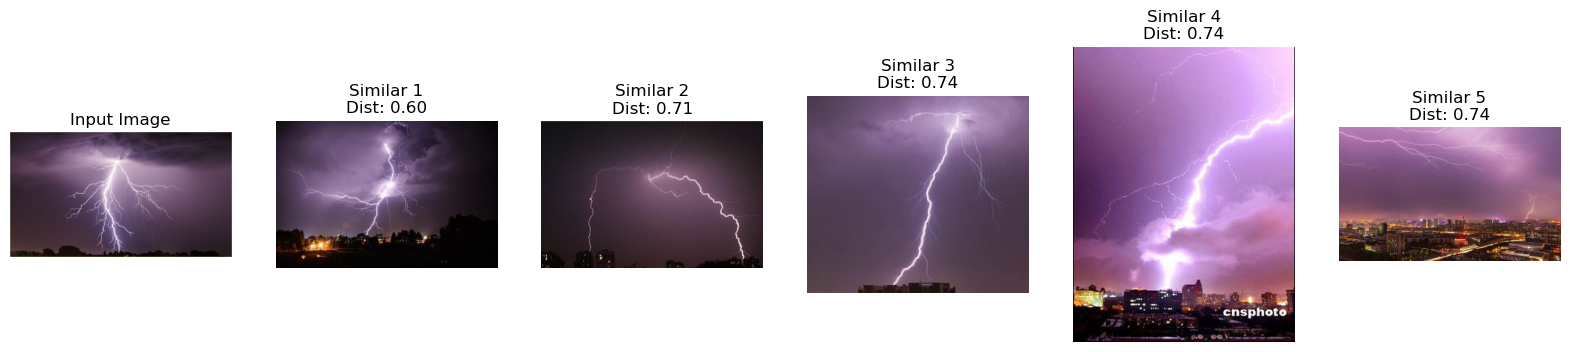

In [64]:

input_img_path = "blitz.jpg"
similar_images = find_similar_images(input_img_path, model, embeddings, database_image_paths, histograms)
#print("Plotting now similar images...")
#print(similar_images)
#
histograms_commented.display_images(input_img_path, similar_images)